In [11]:
import numpy as np

import scipy.io
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 

import itertools

#extend notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99.5% !important;} </style>"))

# from tslearn.metrics import dtw as time_warping

import ordpy
import tqdm
import igraph


from numpy import linalg as LA
from scipy.signal import find_peaks

In [12]:
# from sklearn.cluster import SpectralClustering
# from sklearn.metrics import silhouette_score

# Functions' definitions

In [13]:
def stdfigsize(scale=1, nrows=1, ncols=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    returns (7*ratio*scale*nrows, 7.*scale*ncols)
    By default: ratio=1.3
    ----------
    Returns (7*ratio*scale*nrows, 7.*scale*ncols).
    """

    return((7*ratio*scale*ncols, 7.*scale*nrows))

In [14]:
%matplotlib inline

#Style definitions
sns.set_style("white")
sns.set_style({"xtick.direction": "out", "ytick.direction": "out"})

rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': stdfigsize(),
    'lines.linewidth': 3
}
mpl.rcParams.update(rcparams)

In [15]:
def normalize(array):
    """
    Normalizes an array between 0 and 1.
    """
    return (array-array.min())/(array.max()-array.min())

In [16]:
#https://github.com/oliviaguest/gini
#last modified 31/05/2020
def gini_faster(data):
    """
    Calculate the Gini coefficient of a numpy array.
    (Allegedly faster implementation to calculate
    the Gini index.)
     
    Parameters
    ----------
    data: list like object.
    ----------
    Returns the Gini index of a list of probabilities.    
    """
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm

#Arthur (modified) line above
    array = np.asarray(data).flatten()
#     array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

def safe_avg_shortpath(ordnet):
    """
    Calculates the average weighted shortest 
    path for a graph removing possible
    infinities.
    
    Parameters
    ----------
    ordinal_network: return of the ordinal_network() function from the ordpy package.
    ----------
    Returns the average weighted shortest path
    calculated after the removal of eventual 
    infinities.
    """
    nodes, edges, weights = ordnet
    
    graph = igraph.Graph(directed=True)
    graph.add_vertices(nodes)
    graph.add_edges(edges)
    graph.vs["label"]  = nodes
    graph.es["weight"] = weights
    
    if not True in np.isinf(graph.shortest_paths(weights='weight')):
        w = np.asarray(graph.shortest_paths(weights='weight'))
        return w.mean()
    else:
        sp = np.asarray(graph.shortest_paths(weights='weight'))
        return np.mean(sp[sp<np.inf])

In [26]:
def full_ordinal_distribution(data, dx=3, taux=1, multi=False):
    """
    Ordinal probability distribution. Ordered and with 
    permutations with zero probability.
    
    Parameter
    ---------
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by 
           `full_ordinal_distribution`).
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    multi : boolean
            If `True`, assumes **data** is multivariate time series. If 
            `False`, **data** is expected to be a one-dimensional 
            array (default: `False`). 
    ---------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.

    """
    if multi==False:
        try:
            ny, nx = np.shape(data)
            data   = np.array(data)
        except:
            nx     = np.shape(data)[0]
            ny     = 1
            data   = np.array([data])
            
        partitions = np.concatenate(
            [
                [np.concatenate(data[j:j+1:1,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
                for j in range(ny)
            ]
        )

        symbols = np.apply_along_axis(np.argsort, 1, partitions)
        symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

        probabilities = symbols_count/len(partitions)
        full_symbols  = np.asarray(list(itertools.permutations(np.arange(dx))))

        flat_symbols     = np.apply_along_axis(np.array2string, 1, symbols, separator='')
        full_symbols_str = np.apply_along_axis(np.array2string, 1, full_symbols, separator='')
        full_probs       = np.full(len(full_symbols), 0.)

        for symbol_, probs_ in zip(flat_symbols, probabilities):
            index             = np.argwhere(symbol_==full_symbols_str).flatten()
            full_probs[index] = probs_

        return full_symbols, full_probs
        
    else:
        try:
            ny, nx = np.shape(data)
            data   = np.array(data).T
        except:
            return None

        partitions                  = [np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data]
        flat_symbolic_sequences     = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
        flat_symbols, symbols_count = np.unique(flat_symbolic_sequences, return_counts=True, axis=0)

        probabilities = symbols_count/symbols_count.sum()
        full_symbols  = np.asarray(list(itertools.permutations(np.arange(dx))))

        flat_symbols     = np.apply_along_axis(np.array2string, 1, flat_symbols, separator='')
        full_symbols_str = np.apply_along_axis(np.array2string, 1, full_symbols, separator='')
        full_probs       = np.full(len(full_symbols), 0.)

        for symbol_, probs_ in zip(flat_symbols, probabilities):
            index             = np.argwhere(symbol_==full_symbols_str).flatten()
            full_probs[index] = probs_

        return full_symbols, full_probs

In [25]:
def fisher_shannon(data, dx=3, taux=1, probs=False, multi=False):
    """
    Calculates permutation entropy\\ [#bandt_pompe]_ and Fisher 
    information using an ordinal distribution obtained from data.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by 
           `full_ordinal_distribution`).
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    multi : boolean
            If `True`, assumes **data** is multivariate time series. If 
            `False`, **data** is expected to be a one-dimensional 
            array (default: `False`). 

    Returns
    -------
     : tuple
       Values of permutation entropy and Fisher information.
    """  
    if multi==False:
        if probs==False:
            _, dist_ = full_ordinal_distribution(data, dx, taux)
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)
        else:
            dist_    = data
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)

        if dist_[0]==1. or dist_[-1]==1.: # F = F_0 \sum_{i = 1}^{N - 1} (\sqrt{p_{i+1}} - \sqrt{p_{i}})^2
            return h_, np.sum(np.diff(np.sqrt(dist_[::-1]))**2)  # with F_0=1
        else:
            return h_, 0.5*np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1/2
        
    else:
        if probs==False:
            _, dist_ = full_ordinal_distribution(data, dx, taux, multi=True)
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)
        else:
            dist_    = data
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)

        if dist_[0]==1. or dist_[-1]==1.: # F = F_0 \sum_{i = 1}^{N - 1} (\sqrt{p_{i+1}} - \sqrt{p_{i}})^2
            return h_, np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1
        else:
            return h_, 0.5*np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1/2

In [17]:
def multi_
permutation_entropy(data, dx=3, taux=1, base=2, normalized=True, return_probs=False):
    """
    Calculates Shannon's entropy using an ordinal ditribution extracted from
    data (a multidimensional time series).
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None
    
    partitions                  = [np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data]
    flat_symbolic_sequences     = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    flat_symbols, symbols_count = np.unique(flat_symbolic_sequences, return_counts=True, axis=0)

    probabilities = symbols_count/symbols_count.sum()

    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))

In [18]:
def mwpe(data, dx=3, taux=1, base=2, normalized=True, return_probs=False):
    """
    Multivariate weighted permutation entropy.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None
    
    partitions              = np.asarray([np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data])
    weights                 = partitions.var(axis=2).flatten()
    flat_symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    symbols                 = np.unique(flat_symbolic_sequences, return_counts=False, axis=0)


    total_variance = []
    for symbol in symbols:
        z    = flat_symbolic_sequences==symbol
        z    = z.sum(axis=1)
        args = np.argwhere(z==dx).flatten()
        
        total_variance.append(sum(weights[args]))

    probabilities = total_variance/sum(total_variance)
    
    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))   

In [19]:
def weighted_permutation_entropy(data, dx=3, taux=1, base=2, normalized=True):
    """
    Multivariate weighted permutation entropy.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    data   = np.asarray(data)
    
    partitions              = np.asarray([np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data])
    weights                 = partitions.var(axis=2).flatten()
    flat_symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    symbols                 = np.unique(flat_symbolic_sequences, return_counts=False, axis=0)


    total_variance = []
    for symbol in symbols:
        z    = flat_symbolic_sequences==symbol
        z    = z.sum(axis=1)
        args = np.argwhere(z==dx).flatten()
        
        total_variance.append(sum(weights[args]))

    probabilities = total_variance/sum(total_variance)
    
    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))   

# Disks

<p style="font-size=200px;"><b>Classification:</b></p>

1) Tumbling

2) Chaotic

3) Steady or periodic behavior</p>

In [278]:
#Classifications

shape = 'Circle' #one between 'Circle', 'Square', 'Hexagon', 'Cross

disk_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format(shape))['behaviourHuman'][0]
disk_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format(shape))['behaviourAuto'].flatten()

##########################################################################################
#Data processing

#Improving data structure. Extracting data from dataCircle.mat and loading it into data arrays
disk_data = scipy.io.loadmat('classification/data{}.mat'.format(shape))

#initial condition of the experiments: 0 (dropping with arm holding the paper horizontally) or 1 (dropping vertically)
disk_initcons = []
for i in range(len(disk_data['data'][0])):
    disk_initcons.append(disk_data['data'][0][i]['initialCondition'][0][0][0][0])
disk_initcons = np.asarray(disk_initcons)

# radii of the disks dropped
disk_radii = []
for i in range(len(disk_data['data'][0])):
    disk_radii.append(disk_data['data'][0][i]['radius'][0][0][0][0])
disk_radii = np.asarray(disk_radii)

# camera 1 observable area?
disk_cam1 = []
for i in range(len(disk_data['data'][0])):
    disk_cam1.append(disk_data['data'][0][i]['areaCam1'][0][0].flatten())
disk_cam1 = np.asarray(disk_cam1)

# camera 2 observable area?
disk_cam2 = []
for i in range(len(disk_data['data'][0])):
    disk_cam2.append(disk_data['data'][0][i]['areaCam2'][0][0].flatten())
disk_cam2 = np.asarray(disk_cam2)

# coordinates (x, y, z) along trajectory from 1m high to the floor.
disk_trajectories = []
for i in range(len(disk_data['data'][0])):
    disk_trajectories.append(disk_data['data'][0][i]['trajectory'][0][0])
disk_trajectories = np.asarray(disk_trajectories)

clean_disk_trajectories = []
clean_disk_initcons     = []
clean_disk_class        = []
clean_disk_radii        = []
clean_disk_cam2         = []
clean_disk_cam1         = []

for i in range(len(disk_trajectories)):
    #vertical trajectory
    z                = disk_trajectories[i][::,2]
    # removing the last 5 centimeters of the fall.
    trajectory       = disk_trajectories[i][z>.05]
    
    #removing from area series, the last 5cm of the fall
#     cut_5pc   = len(z)-len(z[z>.05])
    area_cam2 = disk_cam2[i][z>.05] #[:-cut_5pc]
    area_cam1 = disk_cam1[i][z>.05] #[:-cut_5pc]

#(original comment) Segment steady and periodic behaviours from trajectories. 
#We only see steady and periodic from horizontal initial condition.
    if disk_initcons[i]==0:
        tc=1
        
        while np.sqrt(trajectory[::,0][tc]**2 + trajectory[::,1][tc]**2)<.2*disk_radii[i] and tc<len(trajectory[::,1]):
            tc=tc+1
        
#         boolean_trajectory = np.sqrt(trajectory[::,0]**2 + trajectory[::,1]**2)<.2*disk_radii[i]
#         steady_index       = boolean_trajectory.tolist().index(False)

        if tc>2: #(original comment) Segment trajectory into steady(periodic)/unknown if more than 2 time-steps are steady(periodic)
#             pass
#             print(steady_index)
            clean_disk_trajectories.append(trajectory[:steady_index])
            clean_disk_initcons.append(0)
            clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(3)
            clean_disk_cam1.append(area_cam1[:tc])
            clean_disk_cam2.append(area_cam2[:tc])
            
            if len(trajectory[steady_index:])>10: #second part of the sliced original trajectory.
                clean_disk_trajectories.append(trajectory[steady_index:])
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                clean_disk_cam1.append(area_cam1[tc:])
                clean_disk_cam2.append(area_cam2[tc:])
                
                
            else: pass
        
        else: #no segmentation; only one behavior through the whole fall
            clean_disk_trajectories.append(trajectory[steady_index:])
            clean_disk_initcons.append(0)
            clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(np.nan)
            clean_disk_cam1.append(area_cam1[tc:])
            clean_disk_cam2.append(area_cam2[tc:])
                
    else: #no trajectory segmentation. Initial condition: vertical drop.
        boolean_trajectory = np.sqrt(trajectory[::,0]**2 + trajectory[::,1]**2)<0.01
        cut_index          = boolean_trajectory.tolist().index(False)
        
        if len(trajectory[cut_index:])>10: #second part of the sliced original trajectory.
            clean_disk_trajectories.append(trajectory[cut_index:])
            clean_disk_initcons.append(1)
            clean_disk_radii.append(disk_radii[i])
            clean_disk_class.append(np.nan)
            clean_disk_cam1.append(area_cam1[cut_index:])
            clean_disk_cam2.append(area_cam2[cut_index:])
            
##################################################################
dx         = []
dy         = []
dz         = []
pathlength = []
time       = []
radius     = []
X          = []
width      = []

for i in range(len(clean_disk_trajectories)):
    stop = 0
    d    = 0 
    
    for j in range(2, len(clean_disk_trajectories[i])):
        if LA.norm(clean_disk_trajectories[i][j]-clean_disk_trajectories[i][j-1])>0.1:
            stop==1
            break
        d = d + LA.norm(clean_disk_trajectories[i][j]-clean_disk_trajectories[i][j-1])
    
    if stop==0:
        pathlength.append(d)
        z = clean_disk_trajectories[i][::,2]
        dz.append(np.absolute(clean_disk_trajectories[i][::,2][-1]-clean_disk_trajectories[i][::,2][0]))
        dy.append(clean_disk_trajectories[i][::,1][-1]-clean_disk_trajectories[i][::,2][1])
        dx.append(clean_disk_trajectories[i][::,0][-1]-clean_disk_trajectories[i][::,0][0])
        time.append(len(clean_disk_trajectories[i])*(1/98))
        
        locs1 = find_peaks(clean_disk_cam1[i])[0]
        locs2 = find_peaks(clean_disk_cam2[i])[0]
        
        Osc    = (len(locs1)+len(locs2))/(2*time[-1])
        SpeedZ = np.std(np.diff(z))
        
        X.append([Osc, SpeedZ])

# np.save('pickles/clean_disk_trajectories.npy', clean_disk_trajectories)
# np.save('pickles/clean_disk_initcons.npy', clean_disk_initcons)    
# np.save('pickles/clean_disk_class.npy', clean_disk_class)       
# np.save('pickles/clean_disk_radii.npy', clean_disk_radii)       
# np.save('pickles/clean_disk_class.npy', clean_disk_class)       

In [198]:
#missing patterns analysis

# dims     = 1
# dx_      = 3
# missing_ = []
# dist_    = []

# for i, st, ts1, ts2, class_ in zip(range(len(clean_disk_trajectories)), clean_disk_trajectories, 
#                                    clean_disk_cam1, clean_disk_cam2, clean_disk_class):

#     if class_==3:
#         missing_.append([np.nan])
        
#     else:
# #         p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#         ts   = np.stack((normalize(ts1), normalize(ts2)), axis=1)
#         temp = [] 
#         size = [np.quantile(range(len(ts)), j).astype('int') for j in np.arange(0.2,1.05,.05)]
#         for i, k in zip(size, range(len(size))):
#             s, p = full_ordinal_distribution(ts[0:i], dx=dx_, multi=True)
#             data = ordpy.missing_patterns((s, p), dx=dx_, return_fraction=False)[1]
#             temp.append(data)
            
#             if k==0 and data>4:
#                 dist_.append([1])
#             elif k==0:
#                 dist_.append([0])
#             else:
#                 pass
                        
#         missing_.append(temp)

In [199]:
# f, ax = plt.subplots()

# for i, series, class_, algo_ in zip(range(len(missing_)), missing_, clean_disk_class, disk_feat_class):
#     if class_==3:
#         pass
#     else:
#         if algo_==1: #tumbling
#             ax.plot(np.arange(0.2,1.05,.05), series, '*', markersize=8, color='red', alpha=.5)
#         elif algo_==2: #chaos
#             ax.plot(np.arange(0.2,1.05,.05), series, 'o', markersize=8, color='blue', zorder=0, alpha=.5)
        
    
# # ax.set_xticks(np.arange(0.2,1.05,.05))

# f.tight_layout()

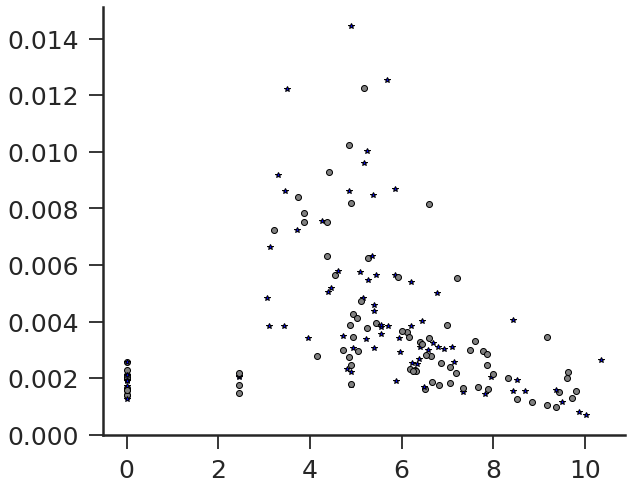

In [280]:
f, ax = plt.subplots()

for (osc, vz), class_ in zip(X, disk_human_class):
    if class_==1:
        ax.plot(osc, vz, 'o', markeredgecolor='black', color='grey')
    elif class_==2:
        ax.plot(osc, vz, '*', markeredgecolor='black', color='blue')
    else:
        pass
#         ax.plot(osc, vz, 's', markeredgecolor='black', color='red')
        
    
f.tight_layout()

## H x C e Fisher x Shannon

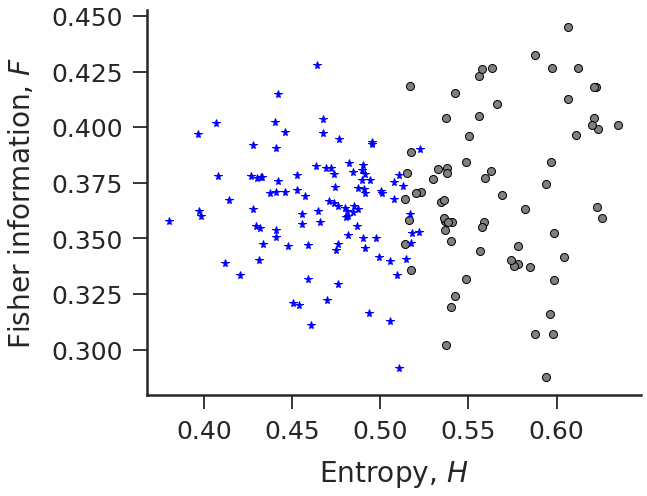

In [243]:
# for ts in clean_disk_trajectories:
#     disk_ce.append(mwpe(ts, dx=4))

dims    = 1
dx_     = 4

disk_ce = []
for i, st, ts1, ts2, class_ in zip(range(len(clean_disk_trajectories)), clean_disk_trajectories, 
                                   clean_disk_cam1, clean_disk_cam2, clean_disk_class):
    if class_==3 or i==38:
        disk_ce.append((np.nan, np.nan))
    else:
#         p  = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        ts = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        disk_ce.append(fisher_shannon(ts, dx=dx_, multi=True))
        
#         disk_ce.append(fisher_shannon(normalize(ts1), dx=dx_, multi=False))


f, ax = plt.subplots()

for (h_, c_), class_ in zip(disk_ce, disk_feat_class): 
# for (h_, c_), class_ in zip(disk_ce, disk_human_class):
    if class_ == 1: #tumbling
        ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color='grey', zorder=0)
    elif class_ == 2: #chaotic
        ax.plot(h_,c_,  '.', marker='*', markersize=8, color='blue')
    if class_ == 3:
        pass

ax.set_ylabel('Fisher information, $F$')
ax.set_xlabel('Entropy, $H$')

f.tight_layout()
# f.savefig('figures/auto-Fisher/Fisher-{}-dx:{}-dims:{}'.format(shape, dx_, dims), bbox_inches='tight')

## PCA

In [228]:
np.min(clean_disk_cam1)

ValueError: operands could not be broadcast together with shapes (129,) (138,) 

In [240]:
for i in clean_disk_cam1:
    print(len(i))

129
138
101
139
118
139
137
89
118
121
140
73
126
124
122
123
150
89
120
30
4
126
143
11
115
10
112
3
136
11
122
117
137
140
140
4
118
136
85
141
125
8
114
143
139
137
132
148
144
131
135
136
114
11
114
91
141
19
99
108
143
13
100
76
117
92
132
25
103
18
75
138
5
122
27
110
4
99
92
93
149
151
131
129
138
8
113
143
151
117
115
134
133
123
128
129
138
11
109
141
3
108
93
139
10
119
16
109
146
8
118
15
105
106
36
90
3
113
121
139
114
145
3
123
69
105
125
147
92
84
9
106
118
99
143
101
123
136
4
134
6
121
137
4
121
117
137
144
3
95
128
147
141
108
3
126
100
90
28
88
4
122
10
102
138
4
117
84
19
66
9
107
6
97
3
114
10
98
123
96
4
126
125
17
109
137
117
131
19
96
117
134
147
117
109
136
121
141
153
3
132
3
85
148
147
11
102
10
123
137
157
110
149
101
21
113
138
85


In [ ]:
X = weights_as_features # shape: (1710, 416) - 1710 amostras diferentes e 416 pesos de arestas de redes ordinais
Y = correct_classes

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25, stratify=Y, random_state=42)

#Number of principal components
npca   = 3
fitted_pca = PCA(n_components=npca).fit(X_train)
#         print('Explained variance: ', fitted_pca.explained_variance_ratio_, fitted_pca.explained_variance_ratio_.sum())

X_train_pca = fitted_pca.transform(X_train)
X_test_pca  = fitted_pca.transform(X_test)

## Trajectories

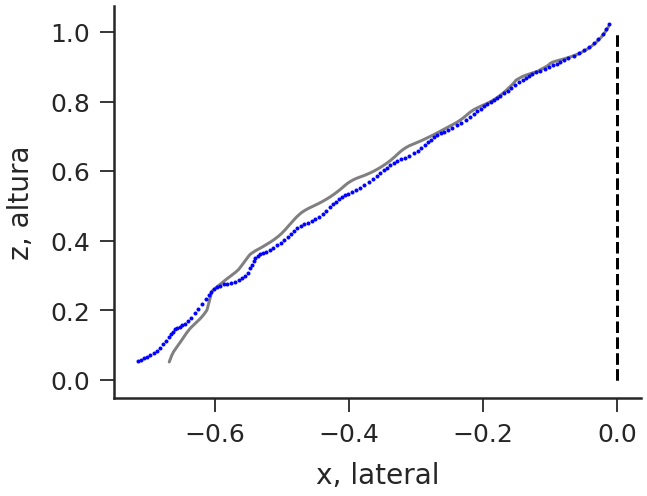

In [208]:
# for i in tqdm.tqdm(range(len(clean_disk_trajectories))):

f, ax = plt.subplots()
for i in [21,6]:
    if i==21:
        x_, z_ = clean_disk_trajectories[i][::,0], clean_disk_trajectories[i][::,2]
        ax.plot(x_, z_, '-', color='grey')
    else:
        x_, z_ = clean_disk_trajectories[i][::,0], clean_disk_trajectories[i][::,2]
        ax.plot(x_, z_, '.', color='blue')

    ax.vlines(x=0, ymin=0, ymax=1, linestyle='--', zorder= 0)
    ax.set_ylabel('z, altura')
    ax.set_xlabel('x, lateral')

    f.tight_layout()
# f.savefig('figures/{}.svg'.format(i), bbox_inches='tight')
# plt.close()

# Hexagons

# Squares

# Crosses